# Estimate ages

Run all cells to:
- Import clinical tables for TCGA and Lund cohorts
- Import and process TCGA and Lund beta decomposition data
- Plot the beta decomposition of 3 example tumors
- Predict S-phase fraction in TCGA tumors
- Estimate proliferation rate, flip rate, mitotic/calendar ages

In [41]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score
from scipy.stats import beta
import EpiClockInvasiveBRCA.src.util as epi_util
consts = epi_util.consts

In [42]:
## Set up output directory for figures
figure_outdir = os.path.join('figures_revision', 'age_estimation')
os.makedirs(figure_outdir, exist_ok=True)

## Prepare data

In [43]:
## Input data directories

Lund_clinical_dir = os.path.join(consts['official_indir'], 'Lund')
Lund_c_beta_dir = os.path.join(consts['repo_dir'], '4. Process Supplementary Data', 'outputs_revision', 'Lund')
beta_peak_indir = os.path.join(consts['official_indir'], 'Beta Peak Decomposition')

## List of PAM50 subtypes considered
subtype_list = ['LumA', 'LumB', 'Her2', 'Basal']

In [44]:
## Import clinical tables for TCGA and Lund cohorts

# Use annotated TCGA clinical table
# Import c_beta values into Lund table

clinical = {}

clinical['TCGA'] = pd.read_table(os.path.join(consts['TCGA_datadir'], 'TCGA.clinical.annotated_revision.tsv'), index_col=0)
clinical['Lund'] = pd.read_table(os.path.join(Lund_clinical_dir, 'Lund.clinical.txt'), index_col=0, dtype={'grade':str})
clinical['Lund']['c_beta'] = pd.read_table(os.path.join(Lund_c_beta_dir, 'Lund.c_beta.txt'), index_col=0).squeeze("columns")

# Create new columns for convenience later
clinical['Lund']['spf'] = clinical['Lund']['spfPercent'] / 100
clinical['Lund']['log_spf'] = np.log(clinical['Lund']['spf'])

# Copy column but rename to "subtype" for consistency
clinical['TCGA']['subtype'] = clinical['TCGA']['subtype.pam50']
clinical['Lund']['subtype'] = clinical['Lund']['genefu.pam50.subtype']

### Import TCGA LUMP data

In [45]:
TCGA_LUMP_values = pd.read_table(os.path.join(consts['TCGA_datadir'], 'TCGA.LUMP_values.tsv'), index_col=0).squeeze('columns')
clinical['TCGA'] = clinical['TCGA'].merge(TCGA_LUMP_values, left_on='Sample.ID', right_index=True, how='left')

### Beta decomposition data

In [46]:
# For both datasets
for dataset in clinical:
    print(f'\n{dataset}')
    
    # Exclude "Normal" subtype tumors
    clinical[dataset] = clinical[dataset].loc[clinical[dataset]['in_analysis_dataset'] & ~clinical[dataset]['c_beta'].isna()]
    
    before = clinical[dataset].shape[0]
    clinical[dataset] = clinical[dataset].loc[clinical[dataset]['subtype'] != 'Normal']
    after = clinical[dataset].shape[0]
    print(f'{before - after} normal-subtype tumors were removed')

    
    # Import modes of the three beta distributions
    modes = pd.read_csv(os.path.join(beta_peak_indir, dataset, 'modes.txt'), sep=' ')
    
    # Need to format the TCGA sample names
    if dataset == 'TCGA':
        modes = modes.rename(index=epi_util.sampleToPatientID)
    
    # Modes of three peaks -- Left = A, Middle, Right = B
    clinical[dataset]['beta_A'] = modes.apply(lambda x: np.sort(x)[0], axis=1)
    clinical[dataset]['beta_middle'] = modes.apply(lambda x: np.sort(x)[1], axis=1)
    clinical[dataset]['beta_B'] = modes.apply(lambda x: np.sort(x)[2], axis=1)

    # Exclude tumors with middle peaks outside of [0.4, 0.6]
    before = clinical[dataset].shape[0]
    clinical[dataset] = clinical[dataset].loc[(clinical[dataset]['beta_middle'] >= 0.4) & (clinical[dataset]['beta_middle'] <= 0.6)]
    after = clinical[dataset].shape[0]
    print(f'{before - after} tumors removed for off-center middle peaks')
    
    # Exclude tumors with left or right peaks on the wrong side of 0.5
    before = clinical[dataset].shape[0]
    clinical[dataset] = clinical[dataset].loc[(clinical[dataset]['beta_A'] < 0.5) & (clinical[dataset]['beta_B'] > 0.5)]
    after = clinical[dataset].shape[0]
    print(f'{before - after} tumors removed for left or right peaks on the wrong side of 0.5')
    
    # Estimates using left and right peaks
    clinical[dataset]['avg_n_flips_estA'] = -np.log(1 - 2 * clinical[dataset]['beta_A']) / 2
    clinical[dataset]['avg_n_flips_estB'] = -np.log(2 * clinical[dataset]['beta_B'] - 1) / 2
    
    # Use the average of the two estimates
    clinical[dataset]['avg_n_flips'] = (clinical[dataset]['avg_n_flips_estA'] + clinical[dataset]['avg_n_flips_estB']) / 2


TCGA
3 normal-subtype tumors were removed
35 tumors removed for off-center middle peaks
0 tumors removed for left or right peaks on the wrong side of 0.5

Lund
7 normal-subtype tumors were removed
8 tumors removed for off-center middle peaks
0 tumors removed for left or right peaks on the wrong side of 0.5


## 3 example tumors w/ beta dists.

In [47]:
## Configure graph
sf = consts['sf']
figsize = np.array([7, 6])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn/T/ipykernel_58710/2439602551.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = beta.pdf(x, a, d) * weight_list[j]
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn/T/ipykernel_58710/243960255

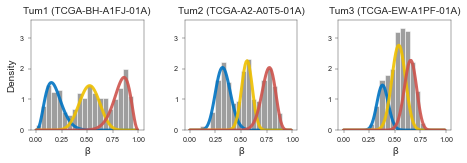

In [48]:
# Need to match tumors in "3 example tumors" section of "c_beta Analysis" notebook
sample_list = {
    'Tum1':'TCGA-BH-A1FJ-01A',
    'Tum2':'TCGA-A2-A0T5-01A',
    'Tum3':'TCGA-EW-A1PF-01A'
}

# Create plot axes
fig, axes = plt.subplots(1, len(sample_list), figsize=np.array(figsize) * [2.3, 0.8] * sf)
fig.tight_layout(pad=0.2)

# Import Clock beta values for TCGA
beta_values_Clock_TCGA = pd.read_table(os.path.join(consts['TCGA_datadir'], 'TCGA.methyl.Clock_revision.tsv'),
                      index_col=0).rename(columns=epi_util.getSampleID)

# Import beta decomposition raw outputs
# i.e. beta distributions' parameters and weights
alpha = pd.read_table(os.path.join(beta_peak_indir, 'TCGA', 'alpha.txt'), sep=' ').rename(index=epi_util.sampleToPatientID)
delta = pd.read_table(os.path.join(beta_peak_indir, 'TCGA', 'delta.txt'), sep=' ').rename(index=epi_util.sampleToPatientID)
phi = pd.read_table(os.path.join(beta_peak_indir, 'TCGA', 'phi.txt'), sep=' ').rename(index=lambda x:epi_util.sampleToPatientID(x.replace('.', '-')))

# Color of each distribution in order (left -> right)
chosen_tumor_colors = [consts['palette_jco'][i] for i in [0, 1, 3]]

for i, tum_id in enumerate(sample_list):
    ax = axes[i]
    samp = sample_list[tum_id]
    patient = epi_util.sampleToPatientID(samp)
    
    # Plot distribution
    sns.histplot(ax=ax, x=beta_values_Clock_TCGA[samp], stat='density',
                 color=consts['palette_jco'][2],
                 bins=20, alpha=consts['opacity'],
                binrange=(0, 1))
    
    # Customize plot
    ax.set_title(f'{tum_id} ({samp})', fontsize=consts['labelfontsize'] * sf)
    ax.set_xlabel('β', fontsize=consts['labelfontsize'] * sf)
    if i == 0: # Only have y-axis label on left-most plot
        ax.set_ylabel('Density', fontsize=consts['labelfontsize'] * sf)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

    # Weight of each of three distributions
    weight_list = phi.loc[patient]
    
    # Holds the max y-axis limit max
    y_max = float('-Inf')
    
    # Plot each distribution
    for j, model in enumerate(alpha.columns):
        
        # Beta dist. parameters
        a = alpha.loc[patient, model]
        d = delta.loc[patient, model]

        # X and Y coords for corve
        x = np.linspace(0, 0.99, 100)
        y = beta.pdf(x, a, d) * weight_list[j]
        
        # Plot curve
        ax.plot(x, y, lw=3, alpha=0.9,
                color=chosen_tumor_colors[j]
               )
        
        # Update max
        y_max = max(y_max, ax.get_ylim()[1])

# Align y-axis limits
for i in range(len(sample_list)):
    ax = axes[i]
    ax.set_ylim(0, y_max * 1.03)

# Save figure
fig.savefig(os.path.join(figure_outdir, 'example_peak_decomp.pdf'), format='pdf', pad_inches=0.1)

## Predictive model for $log(\text{spf})$

In [49]:
## Set training data (Lund)

predictors = [
    'Stroma', 'Lipid', 'IR', 'Mitotic Checkpoint',
    'Mitotic Progression', 'Basal', 'Early Response', 'SR',
    'FGA', 'LUMP'
]

response = 'log_spf'

train_data = clinical['Lund'].loc[clinical['Lund']['in_analysis_dataset'], predictors + [response]].dropna()
train_X = train_data[predictors]
train_y = train_data[response]

## Data we need to predict

TCGA_X = clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], predictors].dropna()

### Fit ElasticNet model

In [50]:
# Grid-search (estimated by cross-validation)

eNetCV = ElasticNetCV(alphas=np.linspace(0.01, 0.99, 20), l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
eNetCV.fit(train_X, train_y)

print(f'alpha = {eNetCV.alpha_}')
print(f'l1 ratio = {eNetCV.l1_ratio_}')

y_pred = eNetCV.predict(train_X)
r2 = r2_score(train_y, y_pred)
print(f'R^2 = {r2:.2f}')

alpha = 0.01
l1 ratio = 0.1
R^2 = 0.68


### Predict spf in TCGA

In [51]:
# Predict and un-transform log(spf) in TCGA
clinical['TCGA'].loc[TCGA_X.index, response] = eNetCV.predict(TCGA_X)
clinical['TCGA']['spf'] = np.exp(clinical['TCGA']['log_spf'])

# Estimate of S-phase in cancer cells
s_phase_duration_hrs = np.mean([12.40, 11.70, 13.60, 12.95, 12.66])
s_phase_duration = s_phase_duration_hrs / 24

# Proliferation rate with 1 day as time unit
# calendar_age_prod_flip_rate is an intermediate value
for dataset in clinical:
    clinical[dataset]['prolif_rate'] = clinical[dataset]['spf'] / s_phase_duration
    clinical[dataset]['calendar_age_prod_flip_rate'] = clinical[dataset]['avg_n_flips'] / clinical[dataset]['prolif_rate']

## DELETE
# Flip rate

# flip_rate_TCGA = clinical['TCGA']['calendar_age_prod_flip_rate'].median() / (3 * 365)
# flip_rate_Lund = clinical['Lund']['calendar_age_prod_flip_rate'].median() / (3 * 365)

# print(f'TCGA-predicted flip rate: {flip_rate_TCGA:.4f}')
# print(f'Lund-predicted flip rate: {flip_rate_Lund:.4f}')

## Estimation

### Estimate flip rate

In [52]:
## Flip rate
## Combine the cohorts to estimate

combined_intermed_df = pd.concat(
    [
        clinical['TCGA'][['in_analysis_dataset', 'calendar_age_prod_flip_rate', 'prolif_rate']],
        clinical['Lund'][['in_analysis_dataset', 'calendar_age_prod_flip_rate', 'prolif_rate']]
    ],
    axis=0)
flip_rate_est = combined_intermed_df.loc[combined_intermed_df['in_analysis_dataset'],
                                         'calendar_age_prod_flip_rate'].median() / (3 * 365)
print(f'Predicted flip rate: {flip_rate_est:.3f}')

Predicted flip rate: 0.002


### Estimate proliferation rate

In [53]:
prolif_rate_est = np.mean(combined_intermed_df['prolif_rate'])

print(f'Estimated proliferation rate: {prolif_rate_est:.2f}')

Estimated proliferation rate: 0.17


### Estimate calendar ages of tumors

In [54]:
## Calculate mitotic and calendar ages

for dataset in clinical:
    clinical[dataset]['mitotic_age'] = clinical[dataset]['avg_n_flips'] / flip_rate_est
    clinical[dataset]['calendar_age_years'] = clinical[dataset]['calendar_age_prod_flip_rate'] / flip_rate_est / 365

In [55]:
## Output statistics on calendar age distribution

combined_calendar = pd.concat(
    [
        clinical['TCGA'][['in_analysis_dataset', 'calendar_age_years']],
        clinical['Lund'][['in_analysis_dataset', 'calendar_age_years']]
    ],
    axis=0)
display(combined_calendar.loc[combined_calendar['in_analysis_dataset'], 'calendar_age_years'].describe())

count    445.000000
mean       4.271278
std        3.950637
min        0.278743
25%        1.646833
50%        3.000000
75%        5.457745
max       29.930965
Name: calendar_age_years, dtype: float64

## Create plots

Wilcoxon rank-sums p-values:


,LumA,LumB,Her2,Basal
LumA,NaN,4.003001e-28,7.589087e-15,1.245462e-29
LumB,NaN,NaN,7.044043e-02,1.919782e-20
Her2,NaN,NaN,NaN,1.416128e-09
Basal,NaN,NaN,NaN,NaN


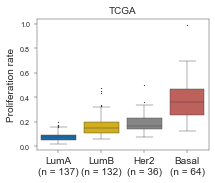

In [56]:
## Plot proliferation rate by subtype in TCGA
## Output Wilcoxon rank-sum p-values instead of using significance bars

clinical['TCGA'].name = 'TCGA'
epi_util.saveBoxPlotNew(clinical['TCGA'], 'subtype.pam50', restrict=True,
                   var_y='prolif_rate', ylabel='Proliferation rate',
                   outdir=figure_outdir, title=True, use_groups=subtype_list,
                   palette=consts['palette_jco'], signif_bar_heights=None,
                   figsize=figsize * [1.1, 1], labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'])

pvalue_tbl = epi_util.getWilcoxonPvalueTable(clinical['TCGA'], 'subtype.pam50', 'prolif_rate', use_groups=subtype_list)
print('Wilcoxon rank-sums p-values:')
display(pvalue_tbl)

Wilcoxon rank-sums p-values:


,LumA,LumB,Her2,Basal
LumA,NaN,0.000757,0.000002,0.000003
LumB,NaN,NaN,0.028248,0.008006
Her2,NaN,NaN,NaN,0.480236
Basal,NaN,NaN,NaN,NaN


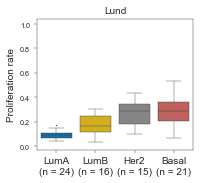

In [57]:
## Plot proliferation rate by subtype in Lund
## Output Wilcoxon rank-sum p-values instead of using significance bars

clinical['Lund'].name = 'Lund'
epi_util.saveBoxPlotNew(clinical['Lund'], 'genefu.pam50.subtype', restrict=True,
                   var_y='prolif_rate', ylabel='Proliferation rate',
                   outdir=figure_outdir, title=True, use_groups = subtype_list,
                   palette=consts['palette_jco'], ylim=(-0.03, 1.04), signif_bar_heights=None,
                   figsize=figsize, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'])

pvalue_tbl = epi_util.getWilcoxonPvalueTable(clinical['Lund'], 'genefu.pam50.subtype', 'prolif_rate', use_groups=subtype_list)
print('Wilcoxon rank-sums p-values:')
display(pvalue_tbl)

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


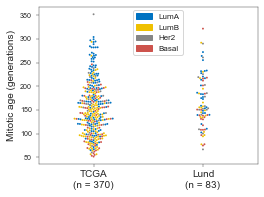

In [58]:
## Plot mitotic age distributions in a swarmplot for both cohorts

# Format plot data
df_ch1 = pd.DataFrame({'mitotic_age':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'mitotic_age'],
                       'Subtype':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'subtype.pam50'],
                       'cohort':'TCGA'}).dropna()
df_ch2 = pd.DataFrame({'mitotic_age':clinical['Lund'].loc[clinical['Lund']['in_analysis_dataset'], 'mitotic_age'],
                       'Subtype':clinical['Lund'].loc[clinical['Lund']['in_analysis_dataset'], 'genefu.pam50.subtype'],
                       'cohort':'Lund'}).dropna()
df_combined = pd.concat([df_ch1, df_ch2], axis=0)

# Set colors
color_list = consts['palette_jco'][:4]
color_dict = dict(zip(subtype_list, color_list))

# Create plot
fig, ax = plt.subplots(figsize=figsize * [1.4, 1.2] * sf)
sns.swarmplot(ax=ax, data=df_combined, x='cohort',
              y='mitotic_age',
              hue='Subtype',
              palette=color_dict,
              legend=False,
             s=12 * sf**2)

# Customize figure
ax.set_xlabel('')
ax.set_ylabel('Mitotic age (generations)', fontsize=consts['labelfontsize'] * sf)
ax.set_xticks(ax.get_xticks(),
                  [group + f'\n(n = {(df_combined["cohort"] == group).sum()})'
                   for group in ['TCGA', 'Lund']])
ax.tick_params(axis='x', labelsize=consts['labelfontsize'] * sf, width=sf, length=8 * sf)
ax.tick_params(axis='y', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Create legend
patches = [mpatches.Patch(color=color_dict[group], label=group) for group in color_dict.keys()]
plots_x, plots_y = ax.get_position().get_points()[1]
fig.legend(handles=patches,
           loc='upper right',
           bbox_to_anchor=(0.65, plots_y + .005),
           fontsize=0.8*consts['labelfontsize'] * sf
          )

# Save figure
fig.savefig(os.path.join(figure_outdir, 'mitotic_age.pdf'), format='pdf', pad_inches=0.1)

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


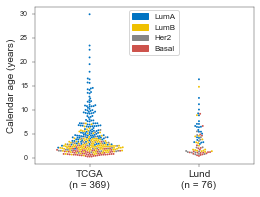

In [59]:
## Plot calendar age distributions in a swarmplot for both cohorts

# Format plot data
df_ch1 = pd.DataFrame({'calendar_age_years':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'calendar_age_years'],
                       'Subtype':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'subtype.pam50'],
                       'cohort':'TCGA'}).dropna()
df_ch2 = pd.DataFrame({'calendar_age_years':clinical['Lund'].loc[clinical['Lund']['in_analysis_dataset'], 'calendar_age_years'],
                       'Subtype':clinical['Lund'].loc[clinical['Lund']['in_analysis_dataset'], 'genefu.pam50.subtype'],
                       'cohort':'Lund'}).dropna()
df_combined = pd.concat([df_ch1, df_ch2], axis=0)

# Set colors
color_list = consts['palette_jco'][:4]
color_dict = dict(zip(subtype_list, color_list))

# Create plot
fig, ax = plt.subplots(figsize=figsize * [1.4, 1.2] * sf)
sns.swarmplot(ax=ax, data=df_combined, x='cohort',
              y='calendar_age_years',
              hue='Subtype',
              palette=color_dict,
              legend=False,
             s=12 * sf**2)

# Customize figure
ax.set_xlabel('')
ax.set_ylabel('Calendar age (years)', fontsize=consts['labelfontsize'] * sf)
ax.set_xticks(ax.get_xticks(),
                  [group + f'\n(n = {(df_combined["cohort"] == group).sum()})'
                   for group in ['TCGA', 'Lund']])
ax.tick_params(axis='x', labelsize=consts['labelfontsize'] * sf, width=sf, length=8 * sf)
ax.tick_params(axis='y', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Create legend
patches = [mpatches.Patch(color=color_dict[group], label=group) for group in color_dict.keys()]
plots_x, plots_y = ax.get_position().get_points()[1]
fig.legend(handles=patches,
           loc='upper right',
           bbox_to_anchor=(0.65, plots_y + .005),
           fontsize=0.8*consts['labelfontsize'] * sf
          )

# Save figure
fig.savefig(os.path.join(figure_outdir, 'calendar_age.pdf'), format='pdf', pad_inches=0.1)

## Create statistics tables

In [60]:
## Returns a Series with the median and IQR of some metric
## Stratified by subtype
def subtypeQuartileSer(sample_annotations, metric, label=None):
    sample_annotations = sample_annotations.loc[sample_annotations['in_analysis_dataset']]
    if label is None:
        label = metric
    
    qrt_func = lambda x:x.quantile([0.25, 0.5, 0.75])
    quartile_df = sample_annotations.groupby('subtype')[metric].apply(qrt_func).unstack().loc[subtype_list]
    quartile_df = pd.concat([quartile_df, sample_annotations[metric].agg(qrt_func).rename('Total').to_frame().T], axis=0)
    quartile_df = np.round(quartile_df, 2)

    quartile_df = quartile_df.astype(str)
    summary_ser = quartile_df[0.50] + ' (' + quartile_df[0.25] + ', ' + quartile_df[0.75] + ')'
    return summary_ser.rename(label)

# Combined cohort
combined_df = pd.concat([clinical['TCGA'], clinical['Lund']], axis=0)

# Combine tables for 3 different metrics
quart_summary_df = pd.concat([
    subtypeQuartileSer(combined_df, 'c_beta', '$c_β$'),
    subtypeQuartileSer(combined_df, 'mitotic_age', 'Mitotic age (Generations)'),
    subtypeQuartileSer(combined_df, 'calendar_age_years', 'Calendar age (Years)')
], axis=1)
quart_summary_df.index.name = ''
display(quart_summary_df)

,$c_β$,Mitotic age (Generations),Calendar age (Years)
,,,
LumA,"0.83 (0.79, 0.86)","171.33 (130.16, 224.99)","6.53 (4.37, 9.65)"
LumB,"0.8 (0.77, 0.82)","138.35 (100.57, 165.26)","2.41 (1.75, 3.39)"
Her2,"0.82 (0.79, 0.84)","163.22 (126.66, 195.04)","2.48 (1.47, 3.39)"
Basal,"0.79 (0.76, 0.83)","137.79 (97.34, 175.39)","1.12 (0.73, 1.63)"
Total,"0.81 (0.78, 0.84)","151.38 (115.04, 193.93)","3.0 (1.65, 5.46)"


In [142]:
## Calculate p-values of Wilcoxon rank-sums test of the mitotic age between different subtypes
## In combined cohort

subtype_pvalue_df = epi_util.getWilcoxonPvalueTable(combined_df, var_cat='subtype', var_y='mitotic_age', use_groups=subtype_list)
subtype_pvalue_df = subtype_pvalue_df.dropna(axis=0, how='all').dropna(axis=1, how='all').fillna(0)
def format_func(x):
    if x == 0:
        return ''
    return f'{x:.0e}'
subtype_pvalue_df = subtype_pvalue_df.applymap(format_func).fillna('')
subtype_pvalue_df.index.name = 'Mitotic Age'
subtype_pvalue_df

/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn/T/ipykernel_80583/908962245.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  subtype_pvalue_df = subtype_pvalue_df.applymap(format_func).fillna('')


,LumB,Her2,Basal
Mitotic Age,,,
LumA,3e-08,2e-01,2e-06
LumB,,2e-03,9e-01
Her2,,,5e-03


In [143]:
## Output statistics tables to a word doc

import docx

def appendTable(doc, df):
    t = doc.add_table(df.shape[0]+1, df.shape[1]+1)

    t.cell(0, 0).text = df.index.name
    
    for i in range(df.shape[0]):
        t.cell(i+1, 0).text = df.index[i]

    for j in range(df.shape[1]):
        t.cell(0, j+1).text = df.columns[j]

    # add the rest of the data frame
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            t.cell(i+1, j+1).text = df.values[i, j]
    
    t.style = 'TableGrid'

doc = docx.Document()

appendTable(doc, quart_summary_df)
doc.add_paragraph()
appendTable(doc, subtype_pvalue_df)

# save the doc
doc.save('./age_tables.docx')

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/docx/styles/styles.py:130: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)
